## Imports

In [27]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn import preprocessing
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import os
from progress.bar import Bar

## Load the data

In [28]:
data_path = "../../dataset/data/"
HM_names = ["H3K27me3", "H3K26me3", "H3K4me1", "H3K4me3", "H3K9me3"]
columns_names = ["geneID", "binID", "HM1", "HM2", "HM3", "HM4", "HM5", "label"]

In [29]:
def load_datasets(folder_name):    
    # ? test.csv
    test_df = pd.read_csv(f"{data_path}{folder_name}/classification/test.csv", header=None, names=columns_names,)
    # ? train.csv
    train_df = pd.read_csv(f"{data_path}{folder_name}/classification/train.csv", header=None, names=columns_names,)
    # ? valid.csv
    valid_df = pd.read_csv(f"{data_path}{folder_name}/classification/valid.csv", header=None, names=columns_names,)
    return (train_df, valid_df, test_df)

In [30]:
def create_dataset(df, maxElements):
    data = []
    labels = []
    genes_inserted = {}

    range_ = range(int(len(df) / 100))
    if maxElements:
        range_ = range_[:maxElements]
    #bar = Bar("\t- creating datasets", max=len(range_))
    for i in range_:  # todo: remove this limit to consider the full dataset
        geneID = df.iloc[i * 100]["geneID"]
        if genes_inserted.get(geneID) is None:
            genes_inserted[geneID] = True

            df_gene = df.loc[df["geneID"] == geneID]

            labels.append(df_gene.iloc[0]["label"])  # ? saving the label once and for all the gene
            # ? extract the whole list of values for the different HMs as a matrix
            # ! I had to put [:100] to limit the errors on the input data (e.i. some genes where duplicates)
            gene_data = [
                list(df_gene["HM1"])[:100],
                list(df_gene["HM2"])[:100],
                list(df_gene["HM3"])[:100],
                list(df_gene["HM4"])[:100],
                list(df_gene["HM5"])[:100],
            ]
            data.append(preprocessing.normalize(gene_data))
        #bar.next()
    #bar.finish()
    return (data, labels)


In [31]:
def to_numpy(data, labels):
    #bar = Bar("\t- converting to numpy format", max=len(data))
    numpy_data = np.array([])
    for gene in data:
        numpy_gene = np.array([])
        for bins in gene:
            numpy_gene = np.append(numpy_gene, np.array(bins))
        numpy_data = np.append(numpy_data, numpy_gene)
        #bar.next()
    #bar.finish()
    numpy_data = numpy_data.reshape(len(data), 5, 100, 1)
    numpy_labels = np.array(labels)
    return numpy_data, numpy_labels

In [38]:
def load(maxFolders=None, maxElements=None):

    full_train_data = np.array([])
    full_valid_data = np.array([])
    full_test_data = np.array([])
    full_train_labels = np.array([])
    full_valid_labels = np.array([])
    full_test_labels = np.array([])

    dirs = os.listdir(data_path)
    if maxFolders:
        dirs = dirs[:maxFolders]    
    for folder in dirs:
        folder_files =  os.listdir(data_path+folder)
        if len(folder_files)==1:
            (train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load_folder(
                folder, maxElements
            )
        else:
            (train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load_clean_data(folder)
            print(f"{folder} loaded")
        
        # append to the full np array
        
        # train
        full_train_data = np.append(full_train_data, train_data)
        full_train_labels = np.append(full_train_labels, train_labels)
        # valid
        full_valid_data = np.append(full_valid_data, valid_data)
        full_valid_labels = np.append(full_valid_labels, valid_labels)
        # test
        full_test_data = np.append(full_test_data, test_data)
        full_test_labels = np.append(full_test_labels, test_labels)

    # ? reshaping
    full_train_data = full_train_data.reshape(len(full_train_labels), 5, 100, 1)
    full_valid_data = full_valid_data.reshape(len(full_valid_labels), 5, 100, 1)
    full_test_data = full_test_data.reshape(len(full_test_labels), 5, 100, 1)

    return (
        (full_train_data, full_train_labels),
        (full_valid_data, full_valid_labels),
        (full_test_data, full_test_labels),
    )

In [39]:
def load_folder(folder_name, maxElements=None):
    print(folder_name)
    # loading the datasets
    print("\tloading")
    train_df, valid_df, test_df = load_datasets(folder_name)

    # create the datasets with the correct format
    print("\tcreating datasets")
    train_data, train_labels = create_dataset(train_df, maxElements)
    valid_data, valid_labels = create_dataset(valid_df, maxElements)
    test_data, test_labels = create_dataset(test_df, maxElements)

    # numpy arrays
    print("\tto numpy")
    train_data, train_labels = to_numpy(train_data, train_labels)
    valid_data, valid_labels = to_numpy(valid_data, valid_labels)
    test_data, test_labels = to_numpy(test_data, test_labels)
    
    # saving data to file
    print("\tsaving data")
    save_data(folder_name, train_data, train_labels, valid_data, valid_labels, test_data, test_labels)

    # return tris of tuples (data,labels)
    return ((train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels))


### Save data

In [40]:
''' 
    save the data in the correct format in order to speed up future loading time
'''
def save_data(folder_name, train_data, train_labels, valid_data, valid_labels, test_data, test_labels):
    train_data = train_data.reshape(len(train_data),5,100)
    valid_data = valid_data.reshape(len(valid_data),5,100)
    test_data = test_data.reshape(len(test_data),5,100)
    # data
    np.save(f"{data_path}{folder_name}/train_data.npy", train_data)
    np.save(f"{data_path}{folder_name}/valid_data.npy", valid_data)
    np.save(f"{data_path}{folder_name}/test_data.npy", test_data)
    # labels
    np.save(f"{data_path}{folder_name}/train_labels.npy", train_labels)
    np.save(f"{data_path}{folder_name}/valid_labels.npy", valid_labels)
    np.save(f"{data_path}{folder_name}/test_labels.npy", test_labels)
    

### Load data

In [41]:
def load_clean_data(folder_name):
    # data
    train_data = np.load(f"{data_path}{folder_name}/train_data.npy")
    valid_data = np.load(f"{data_path}{folder_name}/valid_data.npy")
    test_data = np.load(f"{data_path}{folder_name}/test_data.npy")
    # labels
    train_labels = np.load(f"{data_path}{folder_name}/train_labels.npy")
    valid_labels = np.load(f"{data_path}{folder_name}/valid_labels.npy")
    test_labels = np.load(f"{data_path}{folder_name}/test_labels.npy")
    # return complete tuples
    return ((train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels))

## Create the model

### Load the data

In [ ]:
(train_data, train_labels), (valid_data, valid_labels), (test_data, test_labels) = load()

E003 loaded
E004
	loading
	creating datasets
	to numpy
	saving data
E005
	loading
	creating datasets
	to numpy
	saving data
E006
	loading
	creating datasets
	to numpy
	saving data
E007
	loading
	creating datasets
	to numpy


In [14]:
# visualize some stats about the data
print(f"- {len(train_data)} training genes")
print(f"- {len(valid_data)} validation genes")
print(f"- {len(test_data)} test genes")

- 65990 training genes
- 65990 validation genes
- 65970 test genes


### Model 1
Basic model

In [15]:
train_data = train_data.reshape(len(train_data),5,100,1)
valid_data = valid_data.reshape(len(valid_data),5,100,1)
test_data = test_data.reshape(len(test_data),5,100,1)

In [16]:
model = models.Sequential()
model.add(layers.Flatten(input_shape=(5, 100, 1)))
model.add(layers.Dense(512, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

### Model - DeepChrome

In [17]:
train_data = train_data.reshape(len(train_data),5,100)
valid_data = valid_data.reshape(len(valid_data),5,100)
test_data = test_data.reshape(len(test_data),5,100)

In [18]:
model = models.Sequential()
# stage 1
model.add(layers.Conv1D(10, 5, activation="relu", input_shape=(5,100), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling1D(pool_size=5))
# stage 2
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(625, activation='linear'))
model.add(layers.ReLU())
model.add(layers.Dense(125, activation='linear'))
# stage 3
model.add(layers.Dense(125, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

### Model - UltraChrome

In [11]:
train_data = train_data.reshape(len(train_data),5,100)
valid_data = valid_data.reshape(len(valid_data),5,100)
test_data = test_data.reshape(len(test_data),5,100)

In [12]:
# deepchrome model
model = models.Sequential()
# stage 1 => CNN
model.add(layers.Conv1D(10, 5, activation="relu", input_shape=(5,100), padding="same"))
model.add(layers.BatchNormalization())
model.add(layers.ReLU())
model.add(layers.MaxPooling1D(pool_size=5))
# stage 2 => FNN
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(250, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(625, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(250, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(125, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dense(125, activation='relu'))
# final stage
model.add(layers.Dense(1, activation='sigmoid'))

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 10)             5010      
_________________________________________________________________
batch_normalization_4 (Batch (None, 5, 10)             40        
_________________________________________________________________
re_lu (ReLU)                 (None, 5, 10)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 10)             0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10)                0         
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 625)              

## Train & evaluate the model

In [20]:
model.compile(optimizer="adam", loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=["accuracy"])

history = model.fit(train_data, train_labels, epochs=10, validation_data=(valid_data, valid_labels))

Epoch 1/10
2063/2063 [==============================] - 8s 3ms/step - loss: 0.6477 - accuracy: 0.6305 - val_loss: 0.6270 - val_accuracy: 0.6872
Epoch 2/10
2063/2063 [==============================] - 7s 3ms/step - loss: 0.6141 - accuracy: 0.6372 - val_loss: 0.6121 - val_accuracy: 0.6861
Epoch 3/10
2063/2063 [==============================] - 6s 3ms/step - loss: 0.6097 - accuracy: 0.6375 - val_loss: 0.5975 - val_accuracy: 0.6756
Epoch 4/10
2063/2063 [==============================] - 6s 3ms/step - loss: 0.6033 - accuracy: 0.6394 - val_loss: 0.5825 - val_accuracy: 0.6887
Epoch 5/10
2063/2063 [==============================] - 6s 3ms/step - loss: 0.6036 - accuracy: 0.6375 - val_loss: 0.5861 - val_accuracy: 0.6757
Epoch 6/10
2063/2063 [==============================] - 6s 3ms/step - loss: 0.5998 - accuracy: 0.6412 - val_loss: 0.6150 - val_accuracy: 0.6593
Epoch 7/10
2063/2063 [==============================] - 6s 3ms/step - loss: 0.6014 - accuracy: 0.6424 - val_loss: 0.5961 - val_accuracy:

#### Accuracy

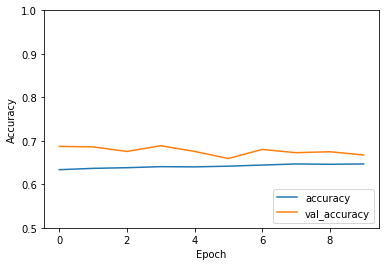

In [21]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim([0.5, 1])
plt.legend(loc="lower right")
plt.show()

#### Loss

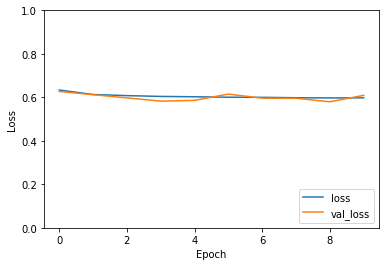

In [22]:
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim([0,1])
plt.legend(loc="lower right")
plt.show()

#### Test accuracy & loss

In [23]:
# check test accuracy and loss
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

2062/2062 - 1s - loss: 0.5526 - accuracy: 0.7508


#### AUC score

In [24]:
m = tf.keras.metrics.AUC()
m.update_state(test_labels,model.predict(test_data))
print(f"AUC: {m.result().numpy()}")

AUC: 0.7598234415054321
